# Proyek Kedua : Membuat Model ML dengan Date Time Series

**Hourly energy consumption time series LSTM**


**Cecep Roni**


Dataset : https://www.kaggle.com/robikscube/hourly-energy-consumption

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
path = ('/content/drive/My Drive/Colab Notebooks/Dicoding_PengembanganML/Submission/HEC/COMED_hourly.csv')
df = pd.read_csv(path)
df.head()

,Datetime,COMED_MW
0,2011-12-31 01:00:00,9970.0
1,2011-12-31 02:00:00,9428.0
2,2011-12-31 03:00:00,9059.0
3,2011-12-31 04:00:00,8817.0
4,2011-12-31 05:00:00,8743.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  66497 non-null  object 
 1   COMED_MW  66497 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


In [5]:
df.shape

(66497, 2)

In [6]:
# Ubah index ke DateTime
df = pd.read_csv(path, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


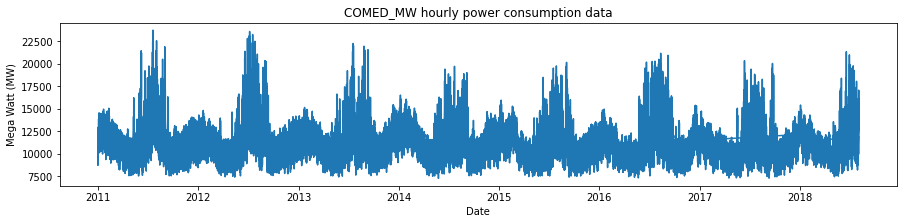

In [7]:
# Visualisasi dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
plt.plot(df)
plt.title('COMED_MW hourly power consumption data')
plt.xlabel('Date')
plt.ylabel('Mega Watt (MW)')
plt.show()

Model dan plot

In [8]:
# get data values
datetime = df.index.values
mw = df['COMED_MW'].values

In [9]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
# Dataset train dan test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(mw, datetime, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

53197 13300


In [11]:
# model
from keras.layers import Dense, LSTM

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(65, return_sequences=True),
  tf.keras.layers.LSTM(65, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [13]:
nilai_maks = df['COMED_MW'].max()
print('Nilai maksimal : ' )
print(nilai_maks)

Nilai maksimal : 
23753.0


In [14]:
nilai_min = df['COMED_MW'].min()
print('Nilai minimal : ' )
print(nilai_min)

Nilai minimal : 
7237.0


In [15]:
x = (nilai_maks - nilai_min) * (10 / 100)
print(x)

1651.6000000000001


In [16]:
# callback
class Call(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < x):
      self.model.stop_training = True
      print("\nNilai MAE < 10% dari skala data")
callbacks = Call()

In [17]:
tf.keras.backend.set_floatx('float64')
history = model.fit(train_set ,epochs=900, validation_data=test_set, callbacks=[callbacks])

Epoch 1/900
532/532 [==============================] - 49s 27ms/step - loss: 11448.6240 - mae: 11449.1202 - val_loss: 11095.5215 - val_mae: 11096.0213
Epoch 2/900
532/532 [==============================] - 12s 22ms/step - loss: 11344.0781 - mae: 11344.5813 - val_loss: 11015.6426 - val_mae: 11016.1396
Epoch 3/900
532/532 [==============================] - 12s 22ms/step - loss: 11276.5381 - mae: 11277.0354 - val_loss: 10949.5654 - val_mae: 10950.0666
Epoch 4/900
532/532 [==============================] - 12s 22ms/step - loss: 11210.5459 - mae: 11211.0532 - val_loss: 10883.1133 - val_mae: 10883.6086
Epoch 5/900
532/532 [==============================] - 12s 22ms/step - loss: 11139.8281 - mae: 11140.3308 - val_loss: 10806.7227 - val_mae: 10807.2252
Epoch 6/900
532/532 [==============================] - 12s 22ms/step - loss: 11056.1445 - mae: 11056.6446 - val_loss: 10714.8691 - val_mae: 10715.3688
Epoch 7/900
532/532 [==============================] - 12s 22ms/step - loss: 10954.1982 - mae:

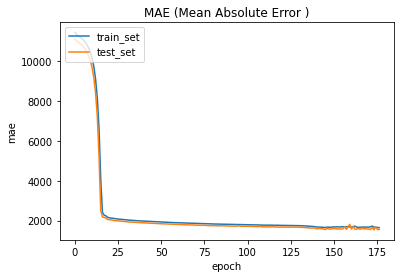

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE (Mean Absolute Error )')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train_set', 'test_set'], loc='upper left')
plt.show()

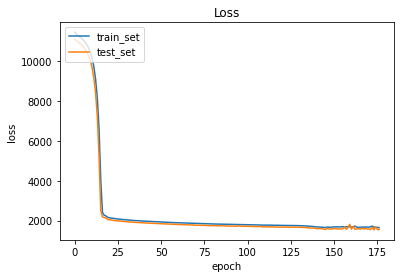

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_set', 'test_set'], loc='upper left')
plt.show()